### Import and Data load

In [19]:
import json
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from collections import Counter

Import tokenized comments from text processing.

In [20]:
root_path = os.path.dirname(os.getcwd())
streamer_comments = json.load(open(os.path.join(root_path, "data", "streamer_tokenized_comments.json"), 'r', encoding='utf-8'))

### Streamer TF-IDF analysis 

Create map idx-streamer map and collect their live chats as a single combined string, or a document appropiate for the next step.

In [21]:
streamer_map = {i: streamer for i, streamer in enumerate(list(streamer_comments.keys()))} 
streamer_chats = [" ".join(chat) for chat in list(streamer_comments.values())]

Generate words based on Term Frequency-Inverse Document Frequency (TF-IDF) with a thresshould of 95%, meaning that the top 5% most frequent words are removed. This is to remove ubiquitous words/terms usually distinguished as Twitch jitter.

In [22]:
tfidf_vectorizer_streamers = TfidfVectorizer(max_df=0.95)  

tfidf_streamers = tfidf_vectorizer_streamers.fit_transform(streamer_chats)

words_streamers = tfidf_vectorizer_streamers.get_feature_names_out()

Function to plot wordmaps based on the TF-IDF for each individual streamer's channel. It has not been run, as it would otherwise fill out the already large notebook.

In [23]:
def show_wordcloud(streamer, tfidf_vector, words):
    scores = tfidf_vector.toarray()[0]
    word_scores = {words[i]: scores[i] for i in range(len(words))}
    
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_scores)
    
    plt.imshow(wc)
    plt.axis("off")
    plt.title(streamer)
    plt.show()

# for idx in range(len(streamer_comments)): #Uncomment to show wordclouds for all streamers
#     show_wordcloud(streamer_map[idx], tfidf_streamers[idx], words_streamers)

### Community TF-IDF Analysis

Load community partition established by the Louvain algorithm in earlier graph analysis.

In [24]:
communities_partition = json.load(open(os.path.join(root_path, 'data', 'communities.json')))

Create a dictionary containing community numbers as keys and a list of streamers assigned to that community.

In [25]:
streamers_in_community = defaultdict(list)

for streamers, community in communities_partition['partition'].items():
    streamers_in_community[community].append(streamers)

streamers_in_community = dict(streamers_in_community)

Remove communities which are isolated.

In [26]:
new_streamers_in_community = {comm: streamers for comm, streamers in streamers_in_community.items() if len(streamers) > 1} # Filter communities with more than one streamer

Generate a dictionary object which contains a representative document for each community. Here we normalize by extracting the amount of tokens equivalent to the channel with the shortest live chat in a community. This might introduce some bias in the sense that we gather only the first messages for each stream, but the alternative would either to randomly select tokens which would remove sentences of text, or another option would be to include all comments. However, regarding the later solution, we found that one or more of the more prominent streamers with live chats that contains many comments would just overflow the whole wordmap.

In [27]:
communities_texts = []
community_map = {}
for idx, (community, streamers) in enumerate(new_streamers_in_community.items()):
    community_text = ""
    min_length = min([len(streamer_comments.get(streamer, [])) for streamer in streamers if len(streamer_comments.get(streamer, [])) > 0]) # Find the minimum length of comments among streamers in the community to normalize tf-idf scores
    for streamer in streamers:
        community_text += " ".join(streamer_comments[streamer][:min_length]) + " "
        
           
    communities_texts.append(community_text)
    community_map[community] = idx

Generate bag of words with TF-IDF, where the process has been identical to the aforementioned for streamers.

In [28]:
tfidf_vectorizer_communities = TfidfVectorizer(max_df=0.95)  

tfidf_communities = tfidf_vectorizer_communities.fit_transform(communities_texts)

words_communities = tfidf_vectorizer_communities.get_feature_names_out()

Here we show the wordmaps due to the lower amount of figures.

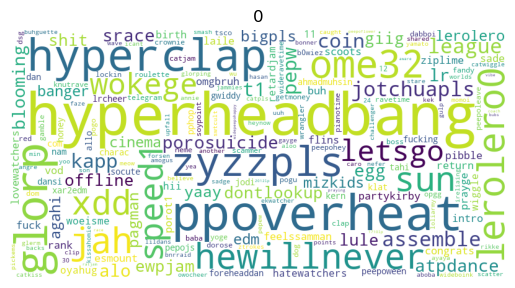

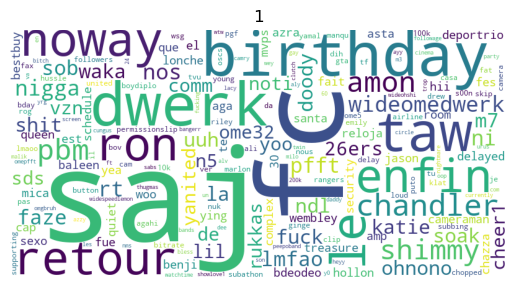

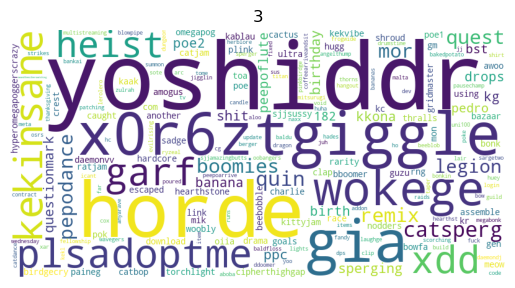

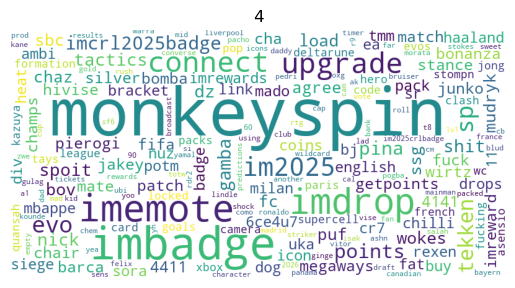

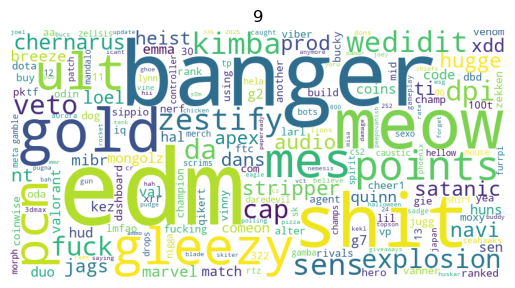

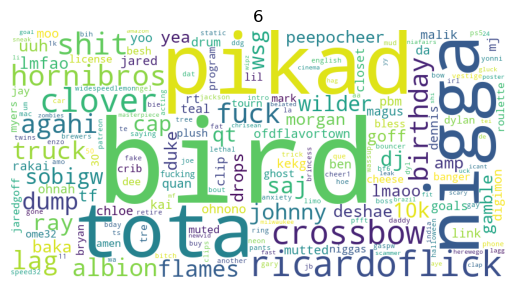

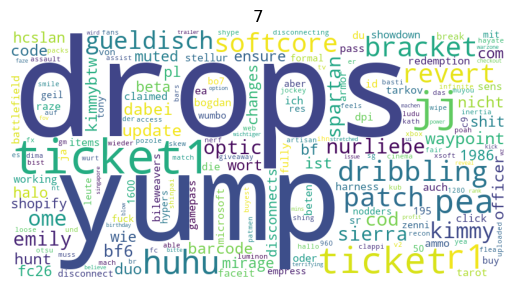

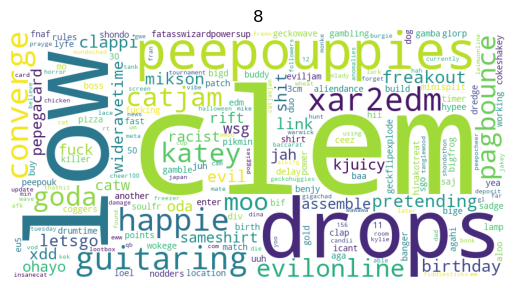

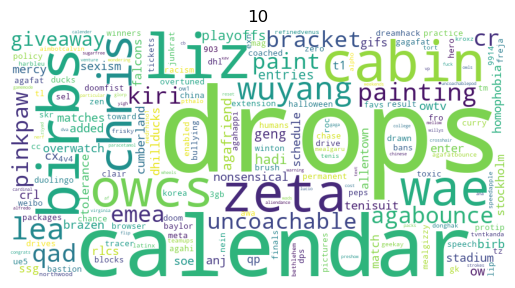

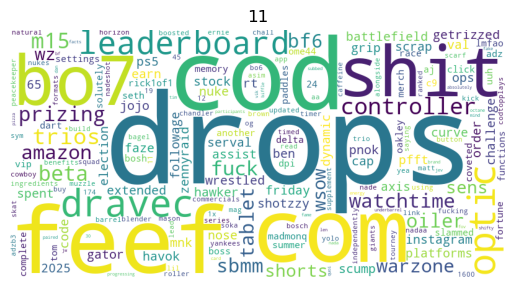

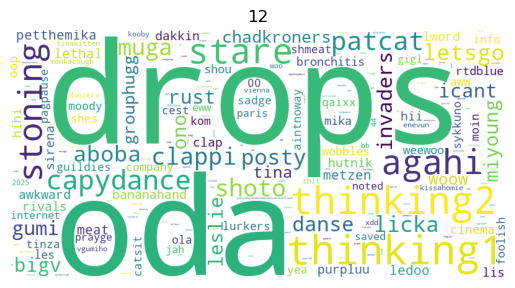

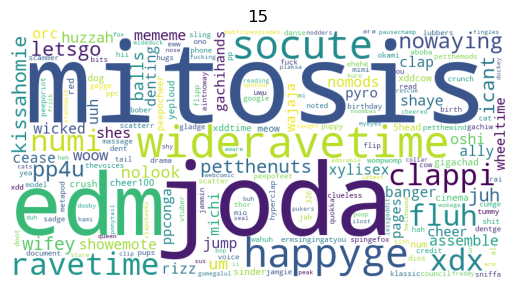

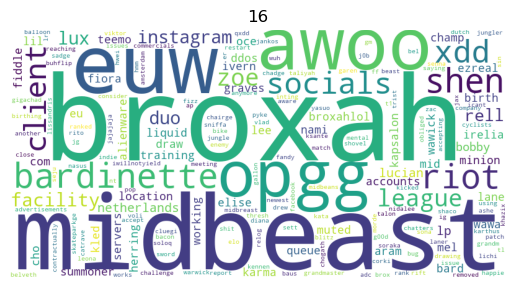

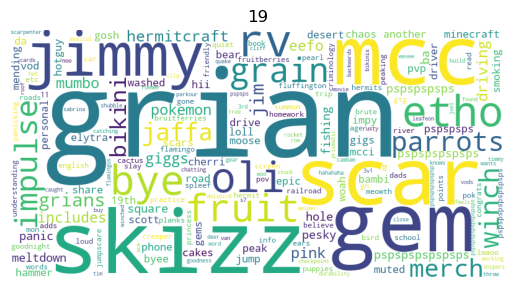

In [29]:
for comm in list(community_map.keys()):
    show_wordcloud(comm, tfidf_communities[community_map[comm]], words_communities)

We see no apparent coherency of language between all streamers, and it suggests that the most common words between streamers are some of the random Twitch jargon. Although, community 1 does seem to have some topical mentions of the First Person Shooter (FPS) game Call of Duty: Black Ops 7 with terms such as "cod" and "bo7", or another FPS video game series - Battlefield - with the term "battlefield". This could indicate that the community has combined streamers with a focus on Shooter games. On the other hand, community 4 does have some significants terms from the popular video game League of Legends (LOL) with terms such as "baus" (prominent streamer within the LOL community), "challenger" (referencing a rank on the leaderboards within the game). Indicating, that this community has combined multiple LOL streamers. However, these findings suggest that to really understand the terms, and the aggregate linguistic profile displayed on the wordmaps, would require a significant knowledge of individual channel slang or topical matters on the Twich platform. Moreover, to increase the complexity of understanding the profiles, a lot of emoticons still make it through the text processing, and these seem to be some of the most significant markers of the languages within each community. Some examples would be: "pepeds", "monkeyspin", "edm", "banger", "meow", "kekeinsanse", "hyperheadbang". These are found in different communities, and they are highly frequent terms based on the TF-IDF.

Next set of code plots a wordmap for a single streamer in this case "hasanabi", and compares it to the wordmap of their assigned community.

*This has been heavily assisted with AI.* 

*Note the streamer was chosen with no apparent reason other than the LLM chose that streamer for the comparison.*

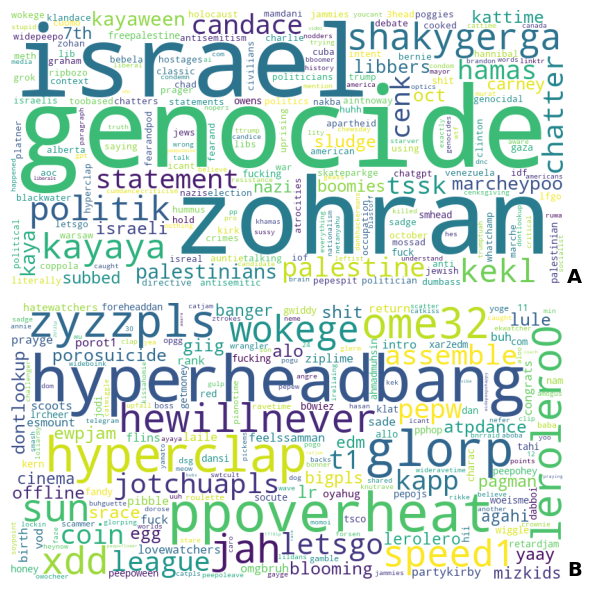

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(16, 6))

streamer_name = 'hasanabi'

# Get streamer index and community
streamer_idx = list(streamer_map.keys())[list(streamer_map.values()).index(streamer_name)]
streamer_community = None
for comm, streamers in new_streamers_in_community.items():
    if streamer_name in streamers:
        streamer_community = comm
        break

# Streamer wordcloud
streamer_scores = tfidf_streamers[streamer_idx].toarray()[0]
streamer_word_scores = {words_streamers[i]: streamer_scores[i] for i in range(len(words_streamers)) if streamer_scores[i] > 0}
wc_streamer = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(streamer_word_scores)

axes[0].imshow(wc_streamer)
axes[0].axis("off")
axes[0].text(1.03, 0, 'A', transform=axes[0].transAxes, fontsize=14, fontweight='bold', va='bottom', ha='right')

# Community wordcloud
community_scores = tfidf_communities[community_map[streamer_community]].toarray()[0]
community_word_scores = {words_communities[i]: community_scores[i] for i in range(len(words_communities)) if community_scores[i] > 0}
wc_community = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(community_word_scores)

axes[1].imshow(wc_community)
axes[1].axis("off")
axes[1].text(1.03, 0, 'B', transform=axes[1].transAxes, fontsize=14, fontweight='bold', va='bottom', ha='right')

plt.tight_layout()
plt.show()

The following code has two parts: 
- calculate_log_likelihood, compares two text corpura and computes G likelihood-ratio test based on observed terms and expected terms.
- keyness_analysis, extracts two corpora one for a streamer and their corresponding community exluding words from the streamer.

*This implementation has been heavily assisted and iterated with AI*

In [31]:
def calculate_log_likelihood(o1, o2, e1, e2):
    """Calculate log-likelihood ratio (G2) for keyness analysis."""
    g2 = 0
    if o1 > 0 and e1 > 0:
        g2 += 2 * o1 * np.log(o1 / e1)
    if o2 > 0 and e2 > 0:
        g2 += 2 * o2 * np.log(o2 / e2)
    return g2

def keyness_analysis(streamer_name, streamer_comments, community_streamers):
    """
    Perform keyness analysis comparing a streamer's language to their community baseline.
    
    Args:
        streamer_name: The target streamer
        streamer_comments: Dict of all streamer comments
        community_streamers: List of streamers in the same community
    
    Returns:
        List of (word, streamer_freq, community_freq, g2_score) tuples sorted by G2
    """
    # Corpus 1: Streamer's tokens
    streamer_tokens = streamer_comments.get(streamer_name, [])
    streamer_freq = Counter(streamer_tokens)
    
    # Corpus 2: Community baseline (excluding the target streamer)
    community_tokens = []
    for s in community_streamers:
        if s != streamer_name and s in streamer_comments:
            community_tokens.extend(streamer_comments[s])
    community_freq = Counter(community_tokens)
    
    # Total counts
    n1 = sum(streamer_freq.values())  # Total streamer tokens
    n2 = sum(community_freq.values())  # Total community tokens
    
    if n1 == 0 or n2 == 0:
        return []
    
    # Calculate G2 for each word in streamer's vocabulary
    all_words = set(streamer_freq.keys()) | set(community_freq.keys())
    results = []
    
    for word in all_words:
        o1 = streamer_freq.get(word, 0)  # Observed in streamer
        o2 = community_freq.get(word, 0)  # Observed in community
        
        # Expected frequencies under null hypothesis
        total_word = o1 + o2
        e1 = (n1 * total_word) / (n1 + n2)
        e2 = (n2 * total_word) / (n1 + n2)
        
        if e1 > 0 and e2 > 0:
            g2 = calculate_log_likelihood(o1, o2, e1, e2)
            # Positive if overused by streamer, negative if underused
            if o1 / n1 < o2 / n2:
                g2 = -g2
            results.append((word, o1, o2, g2))
    
    # Sort by G2 score (descending for positive keyness)
    results.sort(key=lambda x: x[3], reverse=True)
    return results


Calculate and extract maximum $G^2$ for each streamer within the community for "Hasanabi", and create a dictionary where the results are stored.

In [32]:
community_streamers = new_streamers_in_community[streamer_community]

streamers_max_g2 = []
for streamer_name in community_streamers:
    if streamer_name in streamer_comments:
        keyness_results = keyness_analysis(streamer_name, streamer_comments, community_streamers)
        if keyness_results:
            max_g2 = max(r[3] for r in keyness_results)
            streamers_max_g2.append((streamer_name, max_g2))

sorted_streamers_max_g2 = sorted(streamers_max_g2, key=lambda x: x[1], reverse=True)

for name, score in sorted_streamers_max_g2:
    print(f"{name}: {score:.2f}")

jenazad: 115872.17
lacari: 107740.49
lirik: 99081.75
erobb221: 87447.61
roflgator: 70274.60
caedrel: 68819.05
forsen: 66920.43
nattynattlol: 53414.92
mizkif: 32402.31
penta: 30625.36
elajjaz: 15683.08
extraemily: 15159.92
xqc: 13876.21
riotgames: 13498.68
caseoh_: 12431.55
fandy: 11427.68
eslcs: 11106.18
zoil: 10639.82
drututt: 8142.48
iwdominate: 8118.47
zajef77: 8087.70
lol_nemesis: 7951.41
thebausffs: 7458.05
paymoneywubby: 6966.18
zy0xxx: 6848.20
willneff: 6600.06
arrav: 6142.63
gorgc: 6047.97
central_committee: 5958.04
stoopzz: 5626.77
welovegames: 5543.87
loltyler1: 4826.97
hasanabi: 4560.83
39daph: 4302.18
itskatchii: 4292.58
denims: 4175.69
cinna: 3530.93
thestockguy: 3422.35
robcdee: 3302.29
nymn: 3290.61
emiru: 3197.51
hutchmf: 2797.27
surefour: 2779.25
cyr: 2568.61
morgpie: 2486.23
nikolarn: 2360.71
pestily: 2289.73
pokelawls: 2254.84
vanillamace: 2218.66
esfandtv: 2136.31
hyoon: 2126.42
glorious_e: 1840.59
quarterjade: 1833.22
spear_shot: 1804.34
jankos: 1709.34
carolinekwa

Based on the keyness analysis, streamers within the community have a high degree of variety when it comes to their most unique word.

This code will make a combined figure with the following:
- The distribution of the maximum recorded $G^2$ score for each streamer within the community. 
- Top N terms found by the keyness analysis of the streamer with the term that achieved the highest recorded $G^2$ score. Notice that the anlysis both consider over- and underused terms compared to the rest of the community.
- Same as the former bulletpoint, but instead the streamer that had the lowest maximum recorded $G^2$ score. 

*This code has through iterations been assisted with AI*

In [35]:
def plot_two_streamers_keyness(community_id, streamer1, streamer2, streamer_comments, new_streamers_in_community, top_n=10):
    """
    Create a visualization showing keyness analysis for two streamers.
    """
    fig = plt.figure(figsize=(10, 6))
    
    ax_s1_pos = plt.subplot2grid((2, 2), (0, 0))
    ax_s1_neg = plt.subplot2grid((2, 2), (0, 1))
    ax_s2_pos = plt.subplot2grid((2, 2), (1, 0))
    ax_s2_neg = plt.subplot2grid((2, 2), (1, 1))
    
    community_streamers = new_streamers_in_community[community_id]
    
    # Streamer 1 Keyness
    keyness_results1 = keyness_analysis(streamer1, streamer_comments, community_streamers)
    top_positive1 = keyness_results1[:top_n]
    top_negative1 = keyness_results1[-top_n:][::-1]
    
    # Streamer 1 Positive
    words_pos1 = [r[0] for r in top_positive1][::-1]
    scores_pos1 = [r[3] for r in top_positive1][::-1]
    colors_pos1 = plt.cm.Greens(np.linspace(0.4, 0.9, len(words_pos1)))
    ax_s1_pos.barh(words_pos1, scores_pos1, color=colors_pos1)
    ax_s1_pos.set_title("Positive Keyness", fontsize=15, fontweight='bold')
    ax_s1_pos.axvline(x=3.84, color='red', linestyle='--', alpha=0.7)
    ax_s1_pos.tick_params(axis='y', labelsize=12)
    
    # Streamer 1 Negative
    words_neg1 = [r[0] for r in top_negative1][::-1]
    scores_neg1 = [r[3] for r in top_negative1][::-1]
    colors_neg1 = plt.cm.Reds(np.linspace(0.4, 0.9, len(words_neg1)))
    ax_s1_neg.barh(words_neg1, scores_neg1, color=colors_neg1)
    ax_s1_neg.set_title("Negative Keyness", fontsize=15, fontweight='bold')
    ax_s1_neg.axvline(x=-3.84, color='red', linestyle='--', alpha=0.7)
    ax_s1_neg.text(1.40, 0, 'A', transform=ax_s1_neg.transAxes, fontsize=17, fontweight='bold', va='bottom', ha='right')
    ax_s1_neg.tick_params(axis='y', labelsize=12)
    ax_s1_neg.yaxis.set_label_position("right")
    ax_s1_neg.yaxis.tick_right()
    
    # Streamer 2 Keyness
    keyness_results2 = keyness_analysis(streamer2, streamer_comments, community_streamers)
    top_positive2 = keyness_results2[:top_n]
    top_negative2 = keyness_results2[-top_n:][::-1]
    
    # Streamer 2 Positive
    words_pos2 = [r[0] for r in top_positive2][::-1]
    scores_pos2 = [r[3] for r in top_positive2][::-1]
    colors_pos2 = plt.cm.Blues(np.linspace(0.4, 0.9, len(words_pos2)))
    ax_s2_pos.barh(words_pos2, scores_pos2, color=colors_pos2)
    ax_s2_pos.set_xlabel('G² Score', fontsize=10)
    ax_s2_pos.axvline(x=3.84, color='red', linestyle='--', alpha=0.7)
    ax_s2_pos.tick_params(axis='y', labelsize=12)
    
    # Streamer 2 Negative
    words_neg2 = [r[0] for r in top_negative2][::-1]
    scores_neg2 = [r[3] for r in top_negative2][::-1]
    colors_neg2 = plt.cm.Oranges(np.linspace(0.4, 0.9, len(words_neg2)))
    ax_s2_neg.barh(words_neg2, scores_neg2, color=colors_neg2)
    ax_s2_neg.set_xlabel('G² Score', fontsize=10)
    ax_s2_neg.axvline(x=-3.84, color='red', linestyle='--')
    ax_s2_neg.text(1.4, 0, 'B', transform=ax_s2_neg.transAxes, fontsize=17, fontweight='bold', va='bottom', ha='right')
    ax_s2_neg.tick_params(axis='y', labelsize=12)
    ax_s2_neg.yaxis.set_label_position("right")
    ax_s2_neg.yaxis.tick_right()
    
    plt.tight_layout()

['grian', 'geminitay']

Plotting keyness comparison between forsen and desperatenasus in community 0


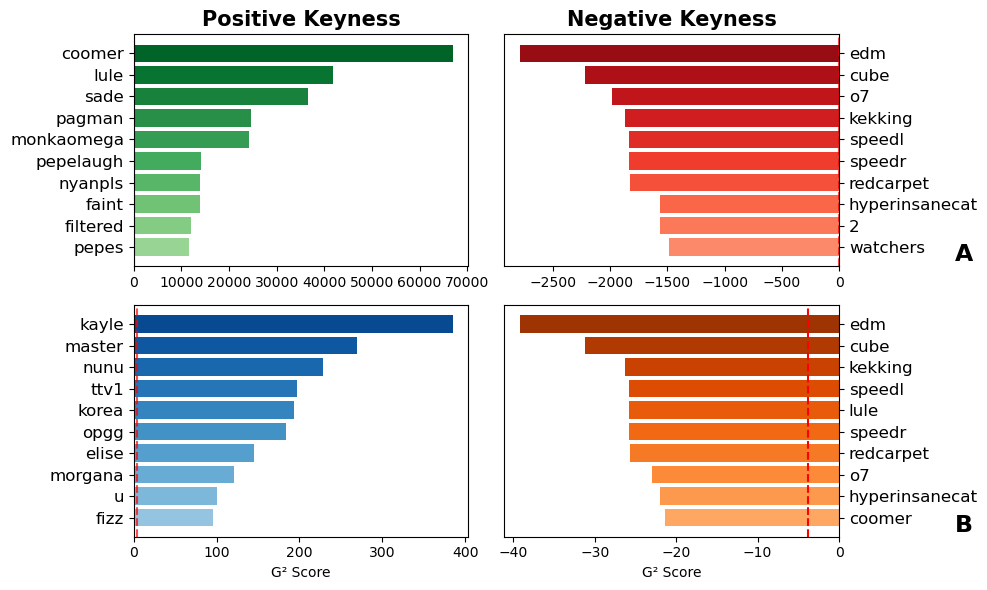

In [42]:
import random
random.seed(1)
# Example: Plot for two random streamers in the community
random_streamers = random.sample(new_streamers_in_community[streamer_community], 2)
print(f"Plotting keyness comparison between {random_streamers[0]} and {random_streamers[1]} in community {streamer_community}")
plot_two_streamers_keyness(streamer_community, random_streamers[0], random_streamers[1], streamer_comments, new_streamers_in_community)


In [34]:
# Calculate average G2 score for all communities with size > 10
community_avg_g2 = []

for community_id, community_streamers in new_streamers_in_community.items():
    if len(community_streamers) > 1:
        max_g2_scores = []
        for streamer_name in community_streamers:
            if streamer_name in streamer_comments:
                keyness_results = keyness_analysis(streamer_name, streamer_comments, community_streamers)
                if keyness_results:
                    max_g2 = max(r[3] for r in keyness_results)
                    max_g2_scores.append(max_g2)
        
        if max_g2_scores:
            avg_g2 = np.mean(max_g2_scores)
            community_avg_g2.append((community_id, avg_g2, len(community_streamers)))

# Sort by average G2 score descending
community_avg_g2.sort(key=lambda x: x[1], reverse=True)

for comm_id, avg_score, size in community_avg_g2:
    print(f"Community {comm_id} (size: {size}): Avg G² = {avg_score:.2f}")

Community 0 (size: 88): Avg G² = 11661.74
Community 1 (size: 25): Avg G² = 8145.39
Community 6 (size: 37): Avg G² = 6064.74
Community 8 (size: 125): Avg G² = 5681.17
Community 7 (size: 12): Avg G² = 4772.90
Community 15 (size: 16): Avg G² = 4624.47
Community 4 (size: 14): Avg G² = 4290.17
Community 3 (size: 50): Avg G² = 4262.41
Community 9 (size: 61): Avg G² = 2265.75
Community 11 (size: 10): Avg G² = 1906.48
Community 12 (size: 14): Avg G² = 1610.71
Community 10 (size: 5): Avg G² = 1145.57
Community 19 (size: 2): Avg G² = 393.00
Community 16 (size: 2): Avg G² = 328.90
